**SMA (Simple Moving Average) crossover strategy**

It is a type of **Trend Following** (momentum) strategy and onsists of a **leading** and a **lagging** simple moving averages.
Leading SMA has a **shorter look-back period** than lagging moving average. Hence, by definition, leading SMA will be more sensitive to most recent price moves; lagging SMA will be slower to react

*  **LONG**: if Leading (short-term) SMA cross above Lagging SMA
*  **SHORT**: if Leading (long-term) SMA cross below Lagging SMA

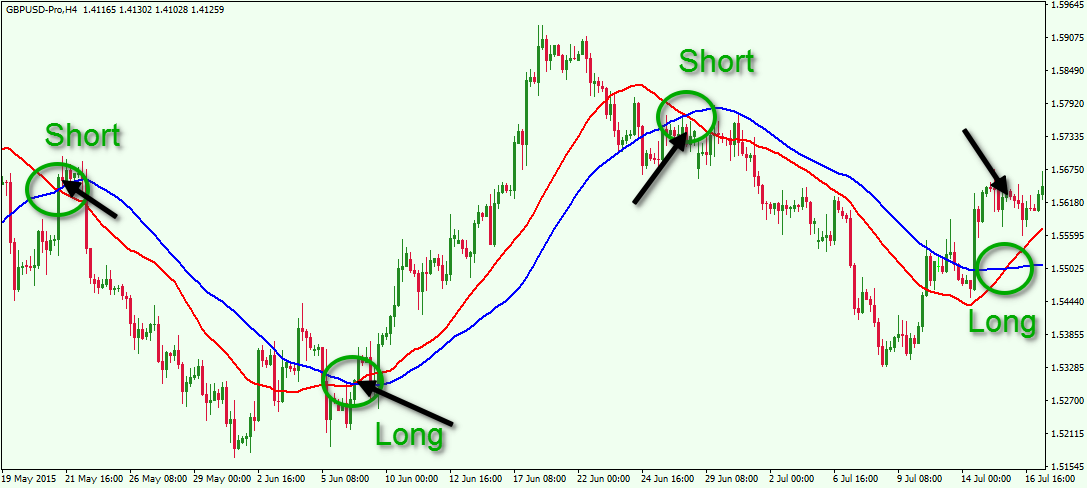


In [183]:
#@title Execute this block to start importing the libraries and helper functions

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None


!pip install -q pyfolio-reloaded
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Interative charting
import altair as alt
alt.data_transformers.disable_max_rows()

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()

    # build the lead/lag indicator
    ma_df['lead'] = ma_df['Close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['Close'].rolling(lag).mean()

    # Remove the NaN rows
    ma_df.dropna(inplace = True)

    # calculate the lead and lag difference
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['Close']

    # signal column will govern the buying and selling logic as described above;
    # 1 means that we are long, -1 means that we are short and 0 means no position
    ma_df['signal'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['signal'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['signal'])

    # Market column as log returns of price series - which is the simple buy-and-hold performance
    ma_df['Buy-Hold'] = np.log(ma_df['Close'] / ma_df['Close'].shift(1))

    # compute our Strategy returns by multiplying signal (shifted forward to match the Market column
    ma_df['Strategy'] = ma_df['signal'].shift(1) * ma_df['Buy-Hold']

    # perform a cumulative sum operation as well as apply an exponent on Market and Strategy log returns
    # in order to recover the original normalised series
    ma_df[['Buy-Hold','Strategy']] = ma_df[['Buy-Hold','Strategy']].cumsum().apply(np.exp)
    return ma_df


import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot the OHLCV chart
def ohlcv(df, date, open, high, low, close, volume):
	rDf = df.reset_index()

	# Create subplots and mention plot grid size
	fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
				   vertical_spacing=0.03,
				   subplot_titles=('OHLC', 'Volume'),
				   row_width=[0.2, 0.7])

	fig.add_trace(go.Ohlc(x=rDf[date],
					  open=rDf[open],
					  high=rDf[high],
					  low=rDf[low],
					  close=rDf[close],
					  name="OHLC"),
					  row=1, col=1)

	# Bar trace for volumes on 2nd row without legend
	fig.add_trace(go.Bar(x=rDf[date], y=rDf[volume], showlegend=False), row=2, col=1)

	# Do not show OHLC's rangeslider plot
	fig.update(layout_xaxis_rangeslider_visible=False)

	fig.show()

In [184]:
#@title 1: Download historical daily data from Yahoo Finance

ticker = 'BTC-USD' # @param ["BTC-USD", "ETH-USD", "NVDA", "0700.HK", "2628.HK", "0941.HK", "0939.HK", "GC=F"] {allow-input: true}
startDate = '2020-01-01' #@param {type:"date"}

stock = yf.Ticker(ticker)

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
df= stock.history(start=startDate)
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'

''' In case Yahoo finance doesn't work, download from github
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/bitcoinHistorical.csv'
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
'''

df

Open           High            Low  \
Date                                                                     
2020-01-01 00:00:00+00:00    7194.892090    7254.330566    7174.944336   
2020-01-02 00:00:00+00:00    7202.551270    7212.155273    6935.270020   
2020-01-03 00:00:00+00:00    6984.428711    7413.715332    6914.996094   
2020-01-04 00:00:00+00:00    7345.375488    7427.385742    7309.514160   
2020-01-05 00:00:00+00:00    7410.451660    7544.497070    7400.535645   
...                                  ...            ...            ...   
2025-01-30 00:00:00+00:00  103709.335938  106418.765625  103321.648438   
2025-01-31 00:00:00+00:00  104737.562500  106026.351562  101543.882812   
2025-02-01 00:00:00+00:00  102402.796875  102755.726562  100297.710938   
2025-02-02 00:00:00+00:00  100661.539062  101430.664062   96216.078125   
2025-02-03 00:00:00+00:00   97618.640625   97618.640625   92584.960938   

                                   Close        Volume  Dividends  \
Date                                                                
2020-01-01 00:00:00+00:00    7200.174316   18565664997        0.0   
2020-01-02 00:00:00+00:00    6985.470215   20802083465        0.0   
2020-01-03 00:00:00+00:00    7344.884277   28111481032        0.0   
2020-01-04 00:00:00+00:00    7410.656738   18444271275        0.0   
2020-01-05 00:00:00+00:00    7411.317383   19725074095        0.0   
...                                  ...           ...        ...   
2025-01-30 00:00:00+00:00  104735.304688   41915744521        0.0   
2025-01-31 00:00:00+00:00  102405.023438   45732764360        0.0   
2025-02-01 00:00:00+00:00  100655.906250   27757944848        0.0   
2025-02-02 00:00:00+00:00   97688.976562   63091816853        0.0   
2025-02-03 00:00:00+00:00   95447.132812  100688420864        0.0   

                           Stock Splits  
Date                                     
2020-01-01 00:00:00+00:00           0.0  
2020-01-02 00:00:00+00:00           0.0  
2020-01-03 00:00:00+00:00           0.0  
2020-01-04 00:00:00+00:00           0.0  
2020-01-05 00:00:00+00:00           0.0  
...                                 ...  
2025-01-30 00:00:00+00:00           0.0  
2025-01-31 00:00:00+00:00           0.0  
2025-02-01 00:00:00+00:00           0.0  
2025-02-02 00:00:00+00:00           0.0  
2025-02-03 00:00:00+00:00           0.0  

[1861 rows x 7 columns]

In [185]:
# Save the dataframe to csv for downloading
df.to_csv('historical.csv')

#2: Visualize and understand the data (Exploratory Data Analysis)
Plot OHLCV (Open/High/Low/Close/Volume) candle sticks

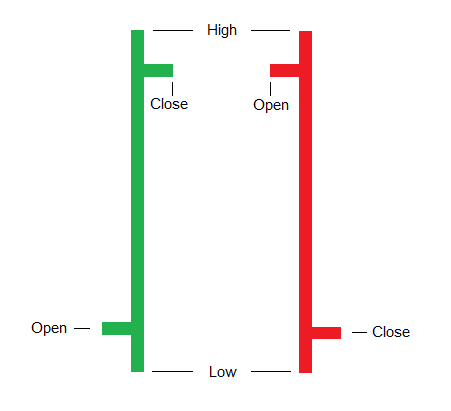

In [186]:
# Filter the start date
#df = df.loc['2020-01-01':]

ohlcv(df, 'Date', 'Open', 'High', 'Low', 'Close', 'Volume')

count    1860.000000
mean        0.001958
std         0.033381
min        -0.371695
25%        -0.012973
50%         0.000645
75%         0.016542
max         0.187465
Name: Close, dtype: float64


<Axes: >

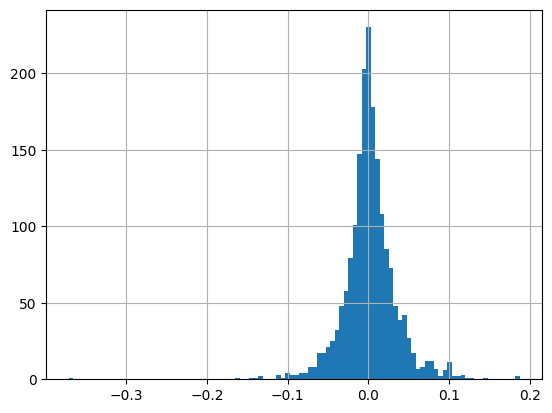

In [187]:
# look at price volatility (closing price change) summary statistics
print(df['Close'].pct_change().describe())
df['Close'].pct_change().hist(bins=100)

In [188]:
lead = 20 # short-term moving average days
lag = 100 # long-term moving average days

df['lead'] = df['Close'].rolling(lead).mean()
df['lag'] = df['Close'].rolling(lag).mean()

COLUMNS = ['Close', 'lead', 'lag']
df[COLUMNS]

Close           lead           lag
Date                                                                 
2020-01-01 00:00:00+00:00    7200.174316            NaN           NaN
2020-01-02 00:00:00+00:00    6985.470215            NaN           NaN
2020-01-03 00:00:00+00:00    7344.884277            NaN           NaN
2020-01-04 00:00:00+00:00    7410.656738            NaN           NaN
2020-01-05 00:00:00+00:00    7411.317383            NaN           NaN
...                                  ...            ...           ...
2025-01-30 00:00:00+00:00  104735.304688  101508.910156  92610.785312
2025-01-31 00:00:00+00:00  102405.023438  101900.831641  92970.513594
2025-02-01 00:00:00+00:00  100655.906250  102209.205078  93295.462109
2025-02-02 00:00:00+00:00   97688.976562  102367.827734  93605.927734
2025-02-03 00:00:00+00:00   95447.132812  102313.482031  93890.252109

[1861 rows x 3 columns]

In [189]:
#@title Plot the SMA cross over
# Rearrange the data into altair format
# altair plots interactive charts with zooming and panning
plot_data = df[COLUMNS].reset_index().melt('Date')

alt.Chart(plot_data).mark_line().encode(
  x='Date:T',
  y='value',
  color='variable'
).properties(
  width=800,
  height=600
).interactive()

alt.Chart(...)

#3: Back testing the strategy with the historical data

Strategy Signal: (1, -1, 0)

*   **1 LONG**: if Leading SMA is above Lagging SMA by the threshold -> hold 1 long position of bitcoin
*   **-1 SHORT**: if Leading SMA is below Lagging SMA by the threshold -> short 1 bitcoin
*   **0 FLAT**: if the difference of Leading and Lagging SMA is less than the threshold -> flatten the bitcoin position


Back testing parameters
*   **lead**: short-term moving average days
*   **lag**: long-term moving average days
*   **threshold**: sensitivity of the strategy and is used to filter out weak signals. **Smaller the number means more sensitive** to the signals (which usually means more long/short positions)

In [190]:
#@title Run back testing with different parameters

lead = 20 #@param {type:"integer"}
lag = 100 #@param {type:"integer"}
threshold = 0.1 #@param {type:"slider", min:0, max:0.5, step:0.01}

ma_df = test_ma(df, lead, lag, threshold).dropna()

SMA_COLUMNS = ['Close', 'lead', 'lag', 'lead-lag', 'pc_diff', 'signal', 'Buy-Hold', 'Strategy']
ma_df[SMA_COLUMNS]

Close           lead           lag  \
Date                                                                    
2020-04-10 00:00:00+00:00    6865.493164    6681.186011   8149.019751   
2020-04-11 00:00:00+00:00    6859.083008    6732.627417   8147.755879   
2020-04-12 00:00:00+00:00    6971.091797    6760.366260   8144.017954   
2020-04-13 00:00:00+00:00    6845.037598    6765.877954   8138.361763   
2020-04-14 00:00:00+00:00    6842.427734    6773.946191   8132.672866   
...                                  ...            ...           ...   
2025-01-30 00:00:00+00:00  104735.304688  101508.910156  92610.785312   
2025-01-31 00:00:00+00:00  102405.023438  101900.831641  92970.513594   
2025-02-01 00:00:00+00:00  100655.906250  102209.205078  93295.462109   
2025-02-02 00:00:00+00:00   97688.976562  102367.827734  93605.927734   
2025-02-03 00:00:00+00:00   95447.132812  102313.482031  93890.252109   

                              lead-lag   pc_diff  signal   Buy-Hold  Strategy  
Date                                                                           
2020-04-10 00:00:00+00:00 -1467.833740 -0.213799      -1   0.940209  1.063593  
2020-04-11 00:00:00+00:00 -1415.128462 -0.206315      -1   0.939332  1.064587  
2020-04-12 00:00:00+00:00 -1383.651694 -0.198484      -1   0.954671  1.047481  
2020-04-13 00:00:00+00:00 -1372.483809 -0.200508      -1   0.937408  1.066771  
2020-04-14 00:00:00+00:00 -1358.726675 -0.198574      -1   0.937051  1.067178  
...                                ...       ...     ...        ...       ...  
2025-01-30 00:00:00+00:00  8898.124844  0.084958       0  14.343197  4.478963  
2025-01-31 00:00:00+00:00  8930.318047  0.087206       0  14.024072  4.478963  
2025-02-01 00:00:00+00:00  8913.742969  0.088557       0  13.784535  4.478963  
2025-02-02 00:00:00+00:00  8761.900000  0.089692       0  13.378223  4.478963  
2025-02-03 00:00:00+00:00  8423.229922  0.088250       0  13.071209  4.478963  

[1761 rows x 8 columns]

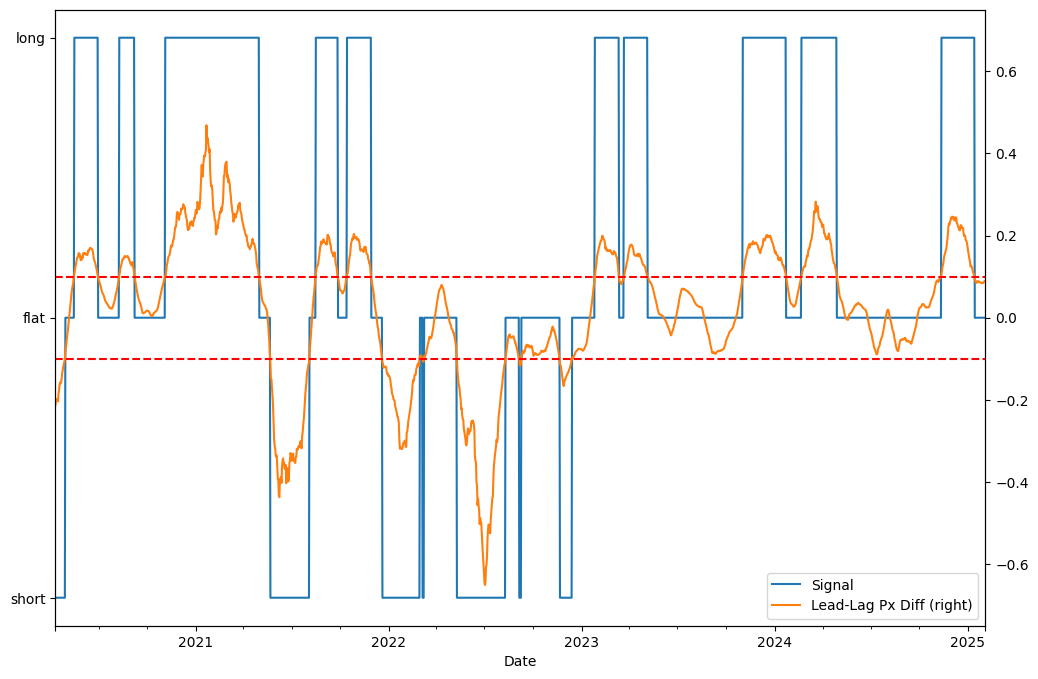

In [191]:
#@title Plot the back test result
# Plot signal over "lead-lag" price difference (align at 0)
# Plot signal as the left y-axis
ax1 = ma_df.signal.plot(label='Signal', legend=True, figsize=(SCREEN_X, SCREEN_Y))
ax1.set_ylim(-1.1, 1.1)
plt.yticks([-1, 0, 1], ['short', 'flat', 'long'])

# Plot "lead-lag" price difference as the right y-axis
ax2 = ma_df.pc_diff.plot(secondary_y=True, label='Lead-Lag Px Diff', legend=True, figsize=(SCREEN_X, SCREEN_Y))
SAFE_MARGIN = 0.05
ylimit = max(round(ma_df.pc_diff.max(), 1), - round(ma_df.pc_diff.min(), 1)) + SAFE_MARGIN
ax2.set_ylim(-ylimit, ylimit)

plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')

### Compare Buy-hold vs SMA Strategy performance

buy_and_hold strategy which benefit from soaring bitcoin price
Strategy: SMA crossover long/short which can benefit from both soaring and dropping bit coin price (provided that the SMA predicted the price movement correctly)

Buy-Hold    13.071209
Strategy     4.478963
Name: 2025-02-03 00:00:00+00:00, dtype: float64


<Axes: xlabel='Date'>

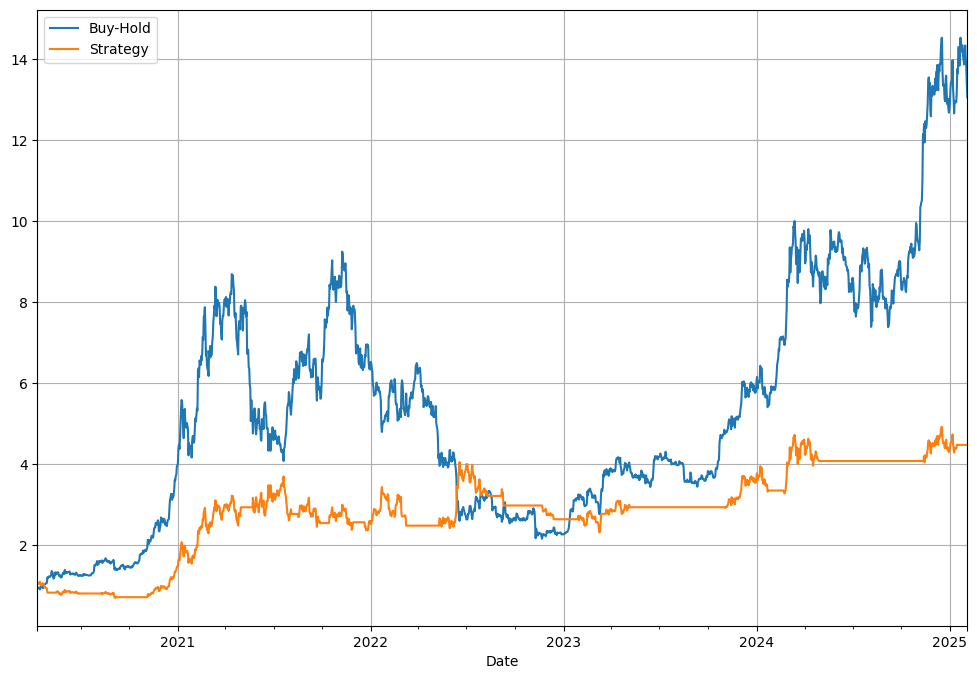

In [192]:
#@title Plot Buy-Hold vs SMA Strategy performance

print(ma_df[['Buy-Hold', 'Strategy']].iloc[-1])
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)

#4. Backtest the strategy with different combination to find the optimal lead/lag params

In [193]:
# start, end, step
leads = np.arange(5, 100, 5)
lags = np.arange(105, 200, 5)

lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)
pnls

5    10   15   20   25   30   35   40   45   50   55   60   65   70  \
105  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
110  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
115  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
120  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
125  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
130  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
135  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
140  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
155  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
160  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
165  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
170  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
175  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
180  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
185  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
190  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
195  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      75   80   85   90   95  
105  NaN  NaN  NaN  NaN  NaN  
110  NaN  NaN  NaN  NaN  NaN  
115  NaN  NaN  NaN  NaN  NaN  
120  NaN  NaN  NaN  NaN  NaN  
125  NaN  NaN  NaN  NaN  NaN  
130  NaN  NaN  NaN  NaN  NaN  
135  NaN  NaN  NaN  NaN  NaN  
140  NaN  NaN  NaN  NaN  NaN  
145  NaN  NaN  NaN  NaN  NaN  
150  NaN  NaN  NaN  NaN  NaN  
155  NaN  NaN  NaN  NaN  NaN  
160  NaN  NaN  NaN  NaN  NaN  
165  NaN  NaN  NaN  NaN  NaN  
170  NaN  NaN  NaN  NaN  NaN  
175  NaN  NaN  NaN  NaN  NaN  
180  NaN  NaN  NaN  NaN  NaN  
185  NaN  NaN  NaN  NaN  NaN  
190  NaN  NaN  NaN  NaN  NaN  
195  NaN  NaN  NaN  NaN  NaN

In [194]:
# Run the strategy with the different combination of lead/lag params
# Calculate the different between market Buy-Hold and strategy performance as PnL
for lead, lag in lead_lags:
  ma_df = test_ma(df, lead, lag, threshold)
  pnls[lead][lag] = ma_df['Strategy'][-1] - ma_df['Buy-Hold'][-1]
  print(lead, lag, pnls[lead][lag])

pnls

5 105 -4.142509340766903
5 110 -6.393188130876606
5 115 -6.5251547676654065
5 120 -4.982081279260499
5 125 -1.778764256279338
5 130 -1.9701012287590522
5 135 -2.127860683263263
5 140 -2.607558436056661
5 145 -4.564826124010675
5 150 -2.953041459333768
5 155 -0.47711705283298045
5 160 -0.8071820989820431
5 165 -1.7750907577324941
5 170 -2.7581878334378853
5 175 -1.8954911839825908
5 180 0.266975355665247
5 185 -1.456982313227332
5 190 -1.2660882534482791
5 195 -0.818129319709163
10 105 -8.374762346677832
10 110 -9.435891426073404
10 115 -7.837913422014431
10 120 -1.1687680059056866
10 125 -1.7795093620913498
10 130 -1.2580277664838455
10 135 -0.02555335749269183
10 140 1.0477236200618876
10 145 -1.0769309381783447
10 150 -1.8790979238669703
10 155 -3.2892524197419597
10 160 -2.962379454969512
10 165 -1.0790743757531622
10 170 -1.6425071551402084
10 175 -2.5533637492151255
10 180 -1.8550051679347188
10 185 -3.1176904557224754
10 190 -1.715413583429875
10 195 -1.958287741946437
15 105 -7.

5         10        15        20         25         30        35  \
105 -4.142509 -8.374762 -7.824032 -9.302145 -10.211392 -10.588567 -9.687587   
110 -6.393188 -9.435891 -6.356535   -8.9624  -8.234676  -9.132489 -9.311912   
115 -6.525155 -7.837913 -4.349841 -6.218492  -5.535171  -8.939346 -8.664391   
120 -4.982081 -1.168768 -3.662909 -2.589154  -2.532187  -5.177476 -7.004901   
125 -1.778764 -1.779509 -3.477592 -0.892752  -2.185515  -4.790258 -7.434042   
130 -1.970101 -1.258028 -2.736083 -3.827296  -3.477231  -4.871539 -5.305521   
135 -2.127861 -0.025553 -1.677166 -3.360369  -3.800457  -3.650601 -3.724149   
140 -2.607558  1.047724 -2.870553 -3.395488  -3.672237    -3.4044 -4.729594   
145 -4.564826 -1.076931 -3.443764 -5.879682  -6.962531  -4.087338 -5.661833   
150 -2.953041 -1.879098 -3.819188 -5.761487  -5.893738  -4.209643 -4.689824   
155 -0.477117 -3.289252 -4.018832 -4.546775  -5.934265  -6.069292 -6.748493   
160 -0.807182 -2.962379 -3.480112 -4.561688  -4.145454  -5.959408 -6.844289   
165 -1.775091 -1.079074 -2.458658 -5.714315  -6.113627  -5.896219 -6.172845   
170 -2.758188 -1.642507 -4.516264 -4.574702   -5.02089  -5.085716 -5.276396   
175 -1.895491 -2.553364 -5.082392 -4.221502  -3.655521  -5.349711  -4.66472   
180  0.266975 -1.855005 -5.067858 -4.692278  -4.449463  -5.447442 -4.923998   
185 -1.456982  -3.11769 -2.570601 -4.304904  -4.549201  -5.113589 -5.471597   
190 -1.266088 -1.715414 -2.610863 -4.354005  -4.252763   -4.99056 -4.623903   
195 -0.818129 -1.958288 -2.859242 -3.293785  -4.615154  -5.746784 -4.268651   

            40         45         50         55        60         65  \
105 -11.278472 -11.000445 -10.962458 -11.583181 -10.86374 -11.077751   
110  -9.533504  -10.12982 -10.005012  -10.01734 -9.334535  -9.118933   
115  -9.508478 -10.195794  -8.990919   -9.95814 -9.241658  -9.031331   
120  -7.487342  -8.272922   -7.07137  -8.599598 -8.266244  -8.179107   
125  -7.881548  -8.124205  -7.962601  -7.515942 -8.069992   -7.10685   
130  -6.331781  -7.192021  -7.052297  -5.954018  -7.02734  -7.235365   
135  -6.109914  -6.688963  -6.665248  -6.464684 -6.880065  -6.881369   
140  -5.052094  -6.144416  -6.544203  -5.816611 -5.379068  -5.760045   
145  -6.066769  -6.751962   -6.47049  -7.358417 -7.154774  -7.643246   
150  -5.783882  -6.270689  -5.767078  -6.541206 -6.741964  -7.623878   
155  -5.807085  -4.931616  -4.899416  -6.507979 -7.466256  -7.046131   
160  -6.508401  -6.040867  -6.164206  -7.388238 -7.869158  -7.421221   
165  -7.060959  -6.249873  -6.219208  -7.453767 -8.289926  -8.162122   
170  -6.063633  -6.271233   -6.83032  -8.002413 -8.294229  -7.916025   
175  -5.958775  -6.432807  -7.389959  -7.785407 -7.700671  -7.545282   
180  -4.970218  -6.979832   -8.11046  -7.712546 -8.304963  -7.570648   
185  -5.613939  -7.062431  -7.364499  -6.976876 -7.575517   -7.62198   
190  -6.106519  -6.788546  -6.579896   -6.26662 -7.359002  -7.241277   
195  -6.238208  -7.156869  -5.680539  -6.242644 -6.811837  -7.008348   

            70         75         80         85         90         95  
105 -12.374701 -13.095478  -13.26769 -13.070252 -13.007132 -12.949308  
110  -11.87219 -12.221201  -12.43839 -12.614394 -12.518787 -12.333608  
115 -11.031268 -10.706243 -11.401422 -11.809825 -11.973645 -11.893089  
120  -9.479748  -9.784652  -9.795911  -9.200522 -10.087275 -10.127721  
125  -8.476152  -9.740867  -9.739845  -9.656739  -9.551319  -10.08381  
130  -6.919606  -8.813457  -9.324037  -9.109058  -8.818157  -9.095329  
135  -7.470392  -8.281706  -9.079946  -8.977171   -8.99586  -8.991276  
140  -6.848105  -8.673535  -8.275063  -8.870278  -8.985087    -8.9803  
145  -8.536797  -9.633181  -9.861103  -9.921263  -9.988903 -10.061794  
150  -7.750212  -8.273626  -8.580966  -9.546013   -9.33269  -9.154117  
155  -7.539462  -8.403905  -8.337547  -8.940739   -9.17001   -9.21337  
160  -7.580719  -8.348144  -7.973972   -8.66898  -9.015826  -9.067943  
165  -7.846155   -8.27688  -8.641587  -9.022766  -9.2

<Axes: >

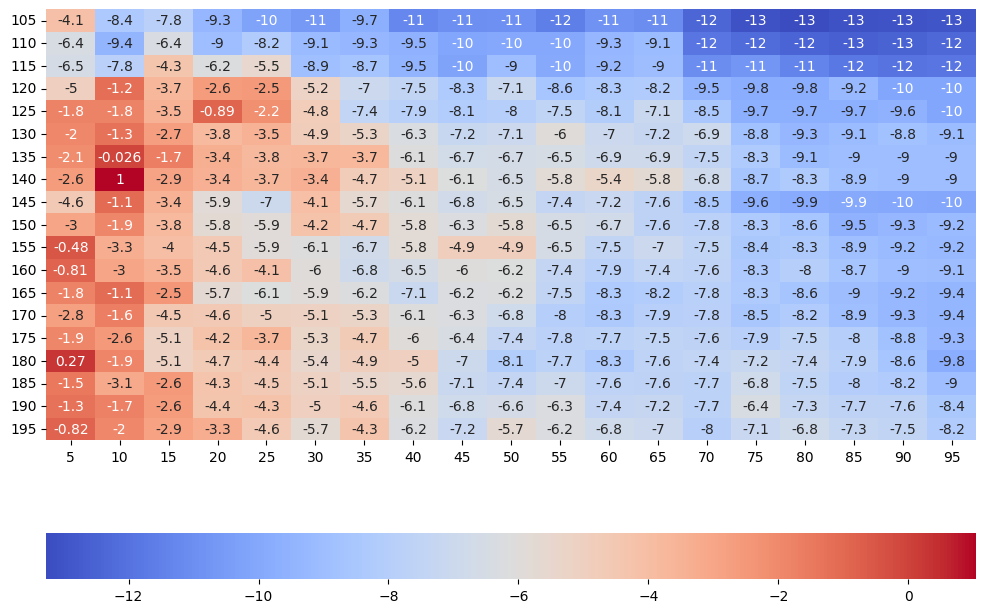

In [195]:
# Use Heatmap to visualize the backtest results
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (SCREEN_X, SCREEN_Y))
sns.heatmap(PNLs, cmap='coolwarm', annot=True, cbar_kws={'orientation': 'horizontal'})

Buy-Hold    9.907952
Strategy    1.492318
Name: 2025-02-03 00:00:00+00:00, dtype: float64

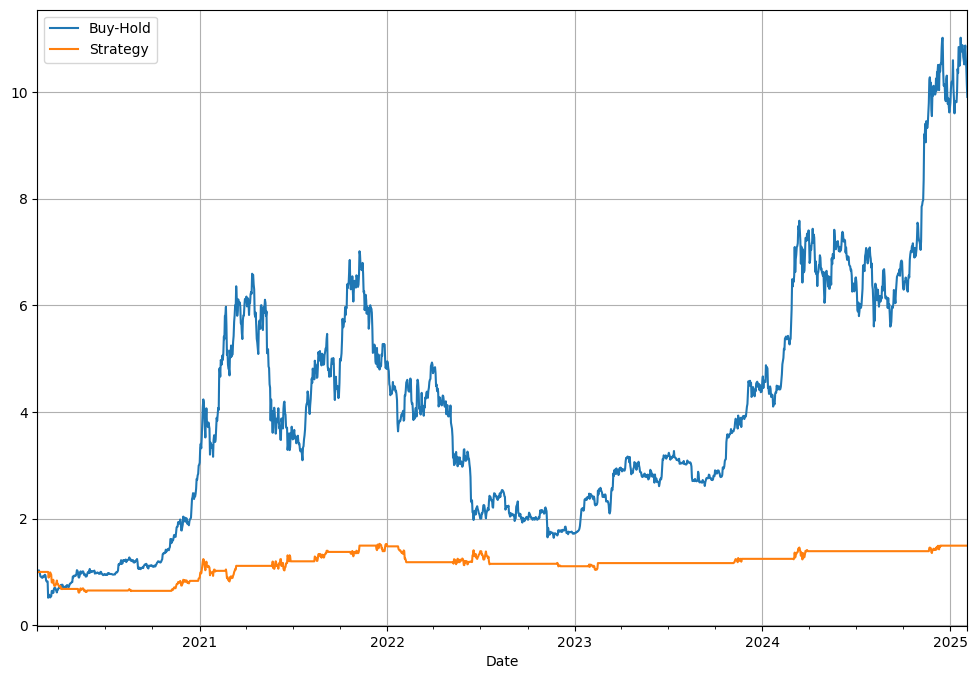

In [196]:
# Run again with the best lead/lag SMA combinations
lead = 20
lag = 50

ma_df = test_ma(df, lead, lag, threshold).dropna()
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)
ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

#5. Show the performance details of SMA strategy

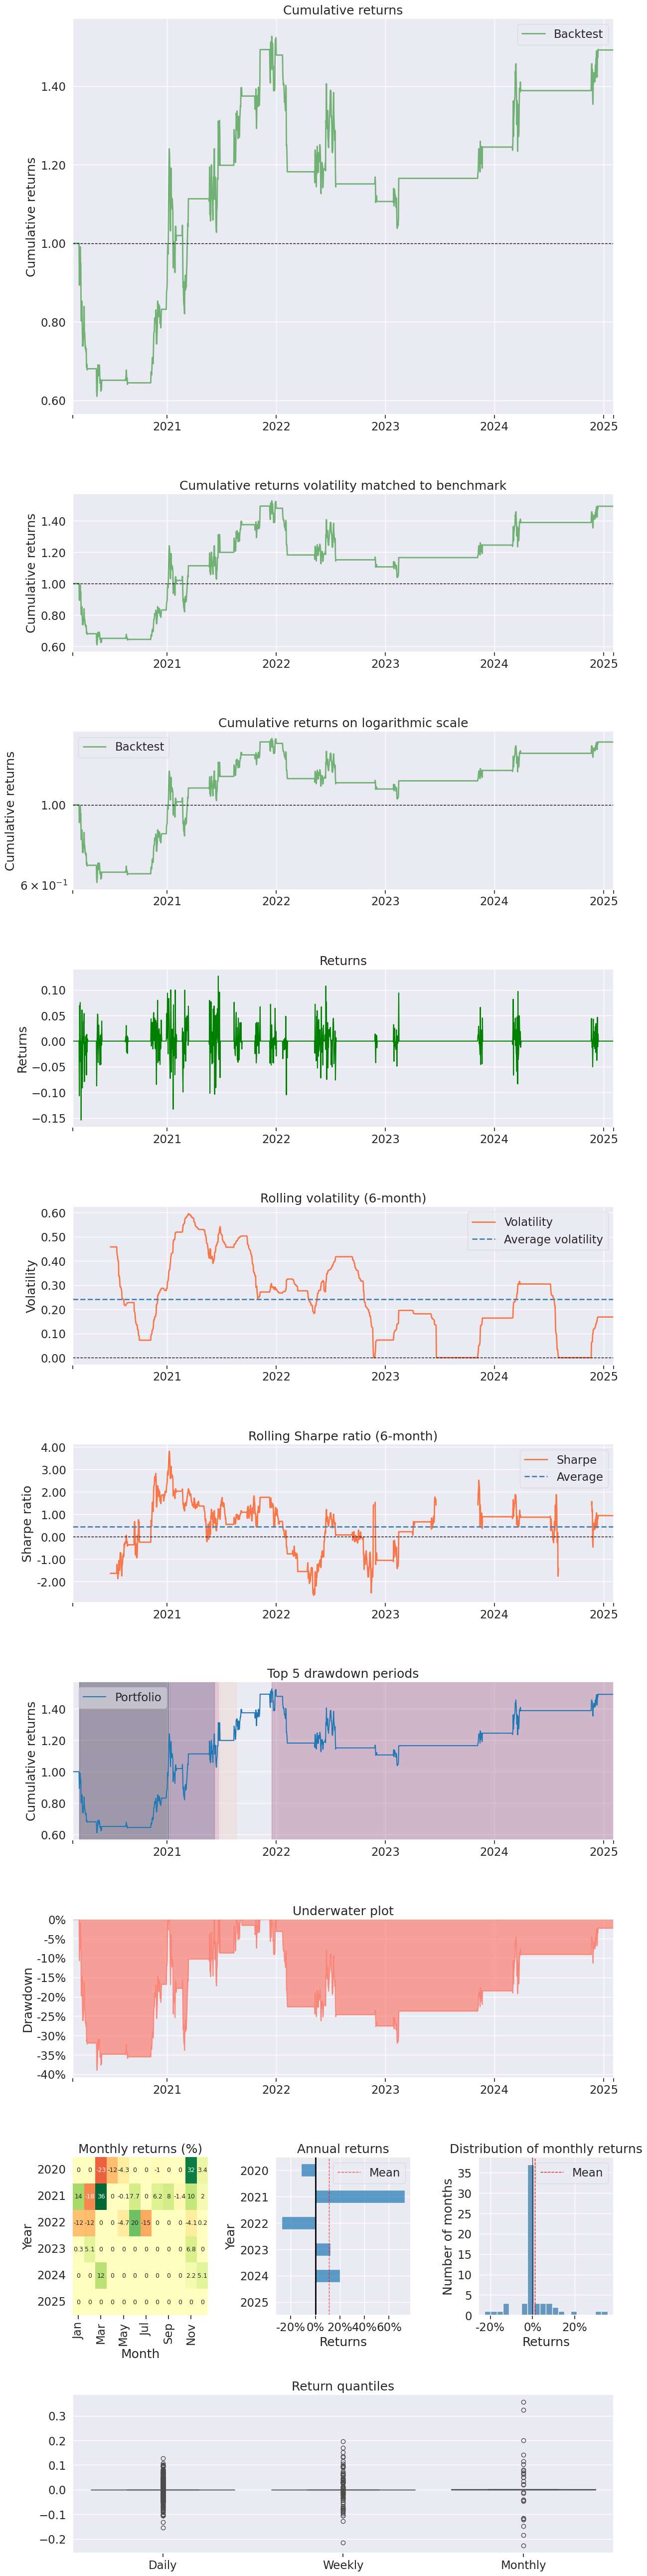

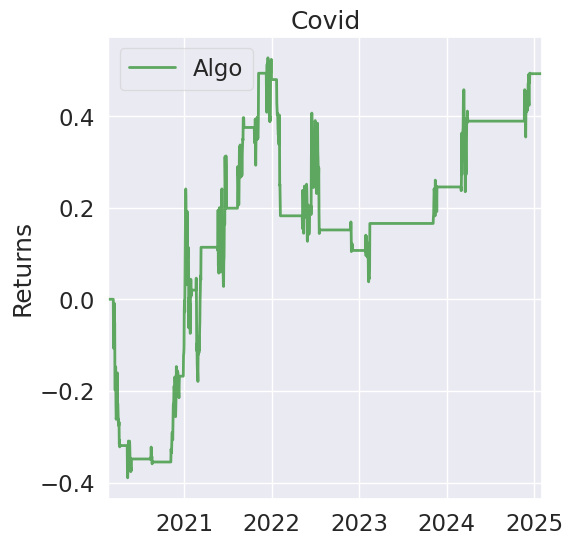

In [197]:
pf.create_full_tear_sheet(ma_df['Strategy'].pct_change())

**Suggestions**

1. Backtest with different **threshold** values
2. Separate the data into 2 portions (**research & back-test**). Optimize the lead/lag/threshold params from the research portion and use back-test data to measure the strategy performance
3. Try different Technical Analysis signals such as **RSI, Bollinger Bands** with TA-Lib (https://pypi.org/project/TA-Lib/)
4. Try other cryptos (e.g. ETH-USD) or stocks (e.g. 0005.HK)
5. Try different data source: https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/DataSource.ipynb
